<a href="https://colab.research.google.com/github/t8trust/CycleGan/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN pour la Transformation d'Images entre Deux Domaines

## Idée Principale
L'objectif de ce projet est d'utiliser un modèle CycleGAN (Generative Adversarial Network avec contrainte de cycle) pour transformer des images d'un domaine à un autre. Par exemple, convertir des photos en peintures artistiques ou inversement.

## Objectifs :
- **Implémenter un CycleGAN avec PyTorch.**
- **Appliquer le modèle pour effectuer des transformations visuelles entre deux domaines d'images.**
- **Visualiser les résultats pour évaluer la qualité des images générées.**

Ce projet comprend les étapes suivantes :
1. **Préparation des données** : Chargement et normalisation des images.
2. **Construction et entraînement des modèles** : Générateurs et discriminateurs pour les deux domaines.
3. **Utilisation du CycleGAN** : Transformation des images et génération de résultats.
4. **Analyse et visualisation** : Comparaison qualitative des images réelles et générées.

## Importation des Bibliothèques

Dans cette section, nous importons toutes les bibliothèques nécessaires au projet, y compris PyTorch pour la construction des modèles, les outils de transformation d'images, et Matplotlib pour la visualisation.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import random
import torchvision.models as models
from PIL import Image
from torchvision.models import VGG19_Weights

Nous définissons les chemins vers les ensembles de données nécessaires au projet, comprenant les images de contenu et de style. Ces chemins permettent de charger les données pour l'entraînement et la validation des modèles.


In [ ]:
image_path = "data/photo_jpg"
style_path = "data/monet_jpg"
augmented_content_path = 'data/augmented_content_images'
augmented_style_path = 'data/augmented_style_images'

### Script pour l'Augmentation des Données

Dans cette section, nous appliquons des transformations aux ensembles de données pour augmenter la diversité des images. Cela inclut des opérations telles que le redimensionnement, le recadrage aléatoire, le retournement horizontal et la normalisation. Ces étapes permettent d'améliorer la robustesse et la généralisation des modèles.

In [ ]:
def random_mirror(image_array):
    """
    Randomly mirrors the image horizontally.
    Args:
        image_array (np.array): Input image array.
    Returns:
        np.array: Horizontally flipped image array.
    """
    if random.random() > 0.5:  # 50% probability
        return np.fliplr(image_array)  # Flip left-to-right
    return image_array

def random_jitter(image_path):
    """
    Applies random jittering by resizing to 286x286 and cropping to 256x256.
    Args:
        image_path (str): Path to the input image.
    Returns:
        np.array: Augmented image array.
    """
    image = Image.open(image_path).convert("RGB")
    image = image.resize((286, 286), Image.Resampling.LANCZOS)  # Resize to 286x286

    # Random crop to 256x256
    left = random.randint(0, 30)
    top = random.randint(0, 30)
    cropped_image = image.crop((left, top, left + 256, top + 256))
    return np.array(cropped_image)

def augment_and_save_images(input_folder, output_folder):
    """
    Augments images with random jittering and mirroring, saves the results.
    Args:
        input_folder (str): Path to the input images folder.
        output_folder (str): Path to save augmented images.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Apply transformations
        jittered_image = random_jitter(input_path)
        mirrored_image = random_mirror(jittered_image)

        # Save the augmented image
        output_path = os.path.join(output_folder, filename)
        Image.fromarray(mirrored_image.astype(np.uint8)).save(output_path)
        print(f"Saved augmented image: {output_path}")

In [ ]:
# Process Content and Style Images
augment_and_save_images(image_path, augmented_content_path)
augment_and_save_images(style_path, augmented_style_path)

Saved augmented image: data/augmented_content_images\00068bc07f.jpg
Saved augmented image: data/augmented_content_images\000910d219.jpg
Saved augmented image: data/augmented_content_images\000ded5c41.jpg
Saved augmented image: data/augmented_content_images\00104fd531.jpg
Saved augmented image: data/augmented_content_images\001158d595.jpg
Saved augmented image: data/augmented_content_images\0033c5f971.jpg
Saved augmented image: data/augmented_content_images\0039ebb598.jpg
Saved augmented image: data/augmented_content_images\003aab6fdd.jpg
Saved augmented image: data/augmented_content_images\003c6c30e0.jpg
Saved augmented image: data/augmented_content_images\00479e2a21.jpg
Saved augmented image: data/augmented_content_images\005f987f56.jpg
Saved augmented image: data/augmented_content_images\0080f94ebc.jpg
Saved augmented image: data/augmented_content_images\00882b7e1d.jpg
Saved augmented image: data/augmented_content_images\009d534136.jpg
Saved augmented image: data/augmented_content_im

### Chargement et Prétraitement des Données

Cette section définit le modèle `ImageDataset`, une classe personnalisée pour charger et transformer des images à partir d'un dossier. Nous appliquons des transformations d'augmentation des données, telles que le redimensionnement, le recadrage aléatoire, le retournement horizontal et la normalisation, afin d'améliorer la diversité des données.

Ensuite, nous combinons les ensembles d'images originales et augmentées pour créer des `DataLoaders`, qui facilitent la gestion des lots lors de l'entraînement. Ces étapes garantissent que les données sont bien préparées et prêtes pour être utilisées dans le modèle.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        PyTorch Dataset for loading and transforming images.

        Args:
            folder_path (str): Path to the folder containing images.
            transform (callable, optional): Transform to be applied to each image.
        """
        self.folder_path = folder_path
        self.image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
image_transforms = transforms.Compose([
    transforms.Resize((286, 286)),              # Resize to 286x286
    transforms.RandomCrop((256, 256)),          # Random crop to 256x256
    transforms.RandomHorizontalFlip(),          # Random mirroring
    transforms.ToTensor(),                      # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize to [-1, 1]
                         std=[0.5, 0.5, 0.5]),
])

# Create datasets for content and style images
content_dataset = ImageDataset(image_path, transform=image_transforms)
augmented_content_dataset = ImageDataset("data/augmented_content_images", transform=image_transforms)
style_dataset = ImageDataset(style_path, transform=image_transforms)
augmented_style_dataset = ImageDataset("data/augmented_style_images", transform=image_transforms)

# Combine datasets into a DataLoader
combined_content_dataset = torch.utils.data.ConcatDataset([content_dataset, augmented_content_dataset])
combined_style_dataset = torch.utils.data.ConcatDataset([style_dataset, augmented_style_dataset])

content_loader = DataLoader(combined_content_dataset, batch_size=1, shuffle=True)
style_loader = DataLoader(combined_style_dataset, batch_size=1, shuffle=True)

# Example usage
for batch in content_loader:
    print(batch.shape)
    break

torch.Size([1, 3, 256, 256])


### Définition du Modèle

Pour ce projet, on a utilisé une architecture CycleGAN avec quelques modifications personnelles.

En particulier, on a remplacé l'architecture ResNet utilisée dans l'article original par une architecture U-Net. Cette modification a été choisie pour une approche plus simple et un entraînement plus rapide, tout en maintenant une qualité satisfaisante des images générées.

### Définition du Générateur

La première étape consiste à définir le générateur. Ce modèle prend une image d'un domaine (par exemple, des images de contenu) et génère une image dans l'autre domaine (par exemple, un style appliqué à l'image de contenu). Le générateur utilise une architecture U-Net pour préserver les détails tout en permettant une conversion fluide entre les domaines.


In [ ]:
# Define the upsample function
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(channels, affine=True)
        )

    def forward(self, x):
        return x + self.block(x)

class CycleGANGenerator(nn.Module):
    def __init__(self, input_channels=3, num_residual_blocks=9):
        super(CycleGANGenerator, self).__init__()

        # Initial Convolution Block
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(inplace=True)
        )

        # Downsampling
        self.downsample = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True),
            nn.ReLU(inplace=True)
        )

        # Residual Blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residual_blocks)]
        )

        # Upsampling
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(inplace=True)
        )

        # Output Layer
        self.output_layer = nn.Sequential(
            nn.Conv2d(64, input_channels, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample(x)
        x = self.residual_blocks(x)
        x = self.upsample(x)
        return self.output_layer(x)

# Instantiate the model
model = CycleGANGenerator(input_channels=3)

# Print the model architecture
print(model)


CycleGANGenerator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = CycleGANGenerator().to(device)
test_input = torch.randn(1, 3, 256, 256).to(device)
output = generator(test_input)
print("Input shape:", test_input.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])


### Définition du Discriminateur

Le discriminateur utilise une architecture de type PatchGAN, qui classe chaque petit patch (région) de l'image en une prédiction de "réel" ou "faux"


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()

        # Initialize the layers
        self.down1 = self._downsample(input_channels, 64)  # (bs, 128, 128, 64)
        self.down2 = self._downsample(64, 128)  # (bs, 64, 64, 128)
        self.down3 = self._downsample(128, 256)  # (bs, 32, 32, 256)

        # Zero padding before convolution
        self.zero_pad1 = nn.ZeroPad2d((0, 1, 0, 1))  # Pad to (bs, 34, 34, 256)

        self.conv = nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0, bias=False)  # (bs, 31, 31, 512)
        self.norm1 = nn.InstanceNorm2d(512, affine=True)  # Instance normalization

        self.leaky_relu = nn.LeakyReLU(0.2)

        # Zero padding before last convolution
        self.zero_pad2 = nn.ZeroPad2d((0, 1, 0, 1))  # Pad to (bs, 33, 33, 512)

        # Last convolution to get the output (real or fake)
        self.last = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)

    def _downsample(self, in_channels, out_channels):
        """Helper function to create downsampling layers (Conv2d + LeakyReLU + InstanceNorm)"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.down1(x)  # (bs, 128, 128, 64)
        x = self.down2(x)  # (bs, 64, 64, 128)
        x = self.down3(x)  # (bs, 32, 32, 256)

        x = self.zero_pad1(x)  # (bs, 34, 34, 256)
        x = self.conv(x)  # (bs, 31, 31, 512)
        x = self.norm1(x)
        x = self.leaky_relu(x)

        x = self.zero_pad2(x)  # (bs, 33, 33, 512)
        x = self.last(x)  # (bs, 30, 30, 1)

        return x

# Instantiate the model
discriminator = Discriminator(input_channels=3)

# Print the model architecture
print(discriminator)

Discriminator(
  (down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (zero_pad1): ZeroPad2d((0, 1, 0, 1))
  (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (leaky_relu): LeakyReLU(negat

### Définition des fonctions de perte

In [ ]:
# LAMBDA for weighting the cycle and identity losses
LAMBDA = 10

# Binary cross-entropy loss for discriminator and generator
loss_obj = nn.BCEWithLogitsLoss()

def discriminator_loss(real, generated):
    """
    Compute the discriminator loss.

    Parameters:
    - real: Predictions on real images.
    - generated: Predictions on generated (fake) images.

    Returns:
    - Discriminator loss.
    """
    # Loss for real images (target = 1)
    real_loss = loss_obj(real, torch.ones_like(real))

    # Loss for generated (fake) images (target = 0)
    generated_loss = loss_obj(generated, torch.zeros_like(generated))

    # Total discriminator loss
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    """
    Compute the generator loss.

    Parameters:
    - generated: Predictions on generated (fake) images.

    Returns:
    - Generator loss.
    """
    return loss_obj(generated, torch.ones_like(generated))

def calc_cycle_loss(real_image, cycled_image):
    """
    Compute the cycle consistency loss.

    Parameters:
    - real_image: Original input image.
    - cycled_image: Image reconstructed after a full cycle.

    Returns:
    - Cycle consistency loss.
    """
    # Mean absolute error (L1 loss)
    loss = torch.mean(torch.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    """
    Compute the identity loss.

    Parameters:
    - real_image: Original input image.
    - same_image: Output image when input is from the target domain.

    Returns:
    - Identity loss.
    """
    # Mean absolute error (L1 loss)
    loss = torch.mean(torch.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Système de Checkpoint

Sauvegarde de l'état du modèle, de l'optimiseur et du numéro d'époque pendant l'entraînement.

In [ ]:
# Define the checkpoint path
checkpoint_path = "./checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)

# Save checkpoint
def save_checkpoint(epoch, generator_g, generator_f, discriminator_x, discriminator_y,
                    generator_g_optimizer, generator_f_optimizer,
                    discriminator_x_optimizer, discriminator_y_optimizer):
    """
    Save model and optimizer states to a checkpoint file.

    Parameters:
    - epoch: Current epoch number.
    - generator_g, generator_f: Generator models.
    - discriminator_x, discriminator_y: Discriminator models.
    - generator_g_optimizer, generator_f_optimizer: Optimizers for the generators.
    - discriminator_x_optimizer, discriminator_y_optimizer: Optimizers for the discriminators.
    """
    checkpoint = {
        'epoch': epoch,
        'generator_g_state_dict': generator_g.state_dict(),
        'generator_f_state_dict': generator_f.state_dict(),
        'discriminator_x_state_dict': discriminator_x.state_dict(),
        'discriminator_y_state_dict': discriminator_y.state_dict(),
        'generator_g_optimizer_state_dict': generator_g_optimizer.state_dict(),
        'generator_f_optimizer_state_dict': generator_f_optimizer.state_dict(),
        'discriminator_x_optimizer_state_dict': discriminator_x_optimizer.state_dict(),
        'discriminator_y_optimizer_state_dict': discriminator_y_optimizer.state_dict(),
    }
    torch.save(checkpoint, os.path.join(checkpoint_path, f"checkpoint_epoch_{epoch}.pth"))
    print(f"Checkpoint saved at epoch {epoch}")

# Load checkpoint
def load_checkpoint(checkpoint_file, generator_g, generator_f, discriminator_x, discriminator_y,
                    generator_g_optimizer, generator_f_optimizer,
                    discriminator_x_optimizer, discriminator_y_optimizer):
    """
    Load model and optimizer states from a checkpoint file.

    Parameters:
    - checkpoint_file: Path to the checkpoint file.
    - generator_g, generator_f: Generator models.
    - discriminator_x, discriminator_y: Discriminator models.
    - generator_g_optimizer, generator_f_optimizer: Optimizers for the generators.
    - discriminator_x_optimizer, discriminator_y_optimizer: Optimizers for the discriminators.

    Returns:
    - epoch: The epoch number stored in the checkpoint.
    """
    if os.path.exists(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        generator_g.load_state_dict(checkpoint['generator_g_state_dict'])
        generator_f.load_state_dict(checkpoint['generator_f_state_dict'])
        discriminator_x.load_state_dict(checkpoint['discriminator_x_state_dict'])
        discriminator_y.load_state_dict(checkpoint['discriminator_y_state_dict'])
        generator_g_optimizer.load_state_dict(checkpoint['generator_g_optimizer_state_dict'])
        generator_f_optimizer.load_state_dict(checkpoint['generator_f_optimizer_state_dict'])
        discriminator_x_optimizer.load_state_dict(checkpoint['discriminator_x_optimizer_state_dict'])
        discriminator_y_optimizer.load_state_dict(checkpoint['discriminator_y_optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Checkpoint loaded from {checkpoint_file} (epoch {epoch})")
        return epoch
    else:
        print(f"No checkpoint found at {checkpoint_file}")
        return 0

### Définition de la classe CycleGAN

La classe `CycleGAN` combine le générateur, le discriminateur et les fonctions de perte pour l'entraînement complet du modèle.

In [ ]:
class CycleGAN(nn.Module):
    def __init__(self,
                 generator_g,
                 generator_f,
                 discriminator_x,
                 discriminator_y,
                 lambda_cycle=10):
        """
        Initialize the CycleGAN model.

        Parameters:
        - generator_g: Generator for X -> Y.
        - generator_f: Generator for Y -> X.
        - discriminator_x: Discriminator for X.
        - discriminator_y: Discriminator for Y.
        - lambda_cycle: Weight for the cycle consistency loss.
        """
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_cycle = lambda_cycle

    def compile(self,
                generator_g_optimizer,
                generator_f_optimizer,
                discriminator_x_optimizer,
                discriminator_y_optimizer,
                gen_loss_fn,
                disc_loss_fn,
                cycle_loss_fn,
                identity_loss_fn):
        """
        Compile the model with optimizers and loss functions.
        """
        self.generator_g_optimizer = generator_g_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, real_x, real_y):
        """
        Perform a single training step.

        Parameters:
        - real_x: Real images from domain X.
        - real_y: Real images from domain Y.
        """
        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        # --------------------------------------------
        # Train Discriminator X
        # --------------------------------------------
        self.discriminator_x_optimizer.zero_grad()

        # Compute loss for real and fake images
        disc_real_x = self.discriminator_x(real_x)
        fake_x = self.generator_f(real_y).detach()
        disc_fake_x = self.discriminator_x(fake_x)

        # Compute discriminator X loss
        d_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        d_x_loss.backward()
        self.discriminator_x_optimizer.step()

        # --------------------------------------------
        # Train Discriminator Y
        # --------------------------------------------
        self.discriminator_y_optimizer.zero_grad()

        # Compute loss for real and fake images
        disc_real_y = self.discriminator_y(real_y)
        fake_y = self.generator_g(real_x).detach()
        disc_fake_y = self.discriminator_y(fake_y)

        # Compute discriminator Y loss
        d_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        d_y_loss.backward()
        self.discriminator_y_optimizer.step()

        # ============================================
        #            TRAIN THE GENERATORS
        # ============================================

        # --------------------------------------------
        # Train Generator G (X -> Y)
        # --------------------------------------------
        self.generator_g_optimizer.zero_grad()

        # Adversarial loss
        fake_y = self.generator_g(real_x)
        disc_fake_y = self.discriminator_y(fake_y)
        g_loss = generator_loss(disc_fake_y)

        # Cycle consistency loss
        cycled_x = self.generator_f(fake_y)
        cycle_loss_x = calc_cycle_loss(real_x, cycled_x)

        # Identity loss
        same_y = self.generator_g(real_y)
        id_loss_y = identity_loss(real_y, same_y)

        # Total generator G loss
        total_g_loss = g_loss + cycle_loss_x + id_loss_y
        total_g_loss.backward(retain_graph=True)
        self.generator_g_optimizer.step()

        # --------------------------------------------
        # Train Generator F (Y -> X)
        # --------------------------------------------
        self.generator_f_optimizer.zero_grad()

        # Adversarial loss
        fake_x = self.generator_f(real_y)
        disc_fake_x = self.discriminator_x(fake_x)
        f_loss = generator_loss(disc_fake_x)

        # Cycle consistency loss
        cycled_y = self.generator_g(fake_x)
        cycle_loss_y = calc_cycle_loss(real_y, cycled_y)

        # Identity loss
        same_x = self.generator_f(real_x)
        id_loss_x = identity_loss(real_x, same_x)

        # Total generator F loss
        total_f_loss = f_loss + cycle_loss_y + id_loss_x
        total_f_loss.backward()
        self.generator_f_optimizer.step()

        return {
            "d_x_loss": d_x_loss.item(),
            "d_y_loss": d_y_loss.item(),
            "g_loss": total_g_loss.item(),
            "f_loss": total_f_loss.item(),
        }

### Fonction pour visualiser les images

Cette fonction permet d'afficher les images générées et réelles pour évaluer la performance du modèle.


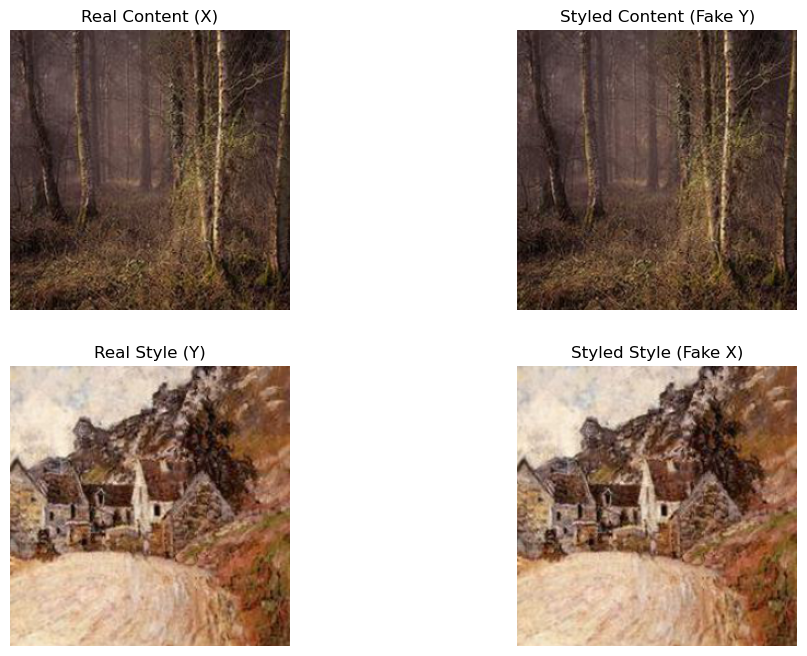

In [ ]:

def denormalize(tensor, mean, std):
    """
    Denormalize a tensor image from [-1, 1] to [0, 1].

    Parameters:
    - tensor: Tensor image to denormalize.
    - mean: Mean values used for normalization.
    - std: Standard deviation values used for normalization.

    Returns:
    - Denormalized tensor image.
    """
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(device)
    tensor = tensor * std + mean  # Reverse normalization
    return tensor

def display_images(real_x, real_y, fake_x, fake_y, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Display real and generated images for visual comparison, with denormalization.

    Parameters:
    - real_x: Real content image.
    - real_y: Real style image.
    - fake_x: Generated content image (from style).
    - fake_y: Generated style image (from content).
    - mean: Mean values used for normalization (default [0.5, 0.5, 0.5]).
    - std: Standard deviation values used for normalization (default [0.5, 0.5, 0.5]).
    """
    # Denormalize the images
    real_x = denormalize(real_x, mean, std)
    real_y = denormalize(real_y, mean, std)
    fake_x = denormalize(fake_x, mean, std)
    fake_y = denormalize(fake_y, mean, std)

    # Convert tensors to CPU and detach for visualization
    real_x_image = real_x.cpu().detach().squeeze(0).permute(1, 2, 0)
    real_y_image = real_y.cpu().detach().squeeze(0).permute(1, 2, 0)
    fake_x_image = fake_x.cpu().detach().squeeze(0).permute(1, 2, 0)
    fake_y_image = fake_y.cpu().detach().squeeze(0).permute(1, 2, 0)

    # Plot the images
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.title("Real Content (X)")
    plt.imshow(real_x_image)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Styled Content (Fake Y)")
    plt.imshow(fake_y_image)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.title("Real Style (Y)")
    plt.imshow(real_y_image)
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.title("Styled Style (Fake X)")
    plt.imshow(fake_x_image)
    plt.axis('off')

sample_real_x = next(iter(content_loader)).to(device)
sample_real_y = next(iter(style_loader)).to(device)
display_images(sample_real_x, sample_real_y, sample_real_y, sample_real_x)


### Initialisation des éléments nécessaires

Ici, nous initialisons les générateurs, les discriminateurs, les optimisateurs, et d'autres paramètres essentiels pour l'entraînement du modèle.


In [ ]:
# Define CycleGAN model
monet_generator = CycleGANGenerator()
photo_generator = CycleGANGenerator()

monet_discriminator = Discriminator(input_channels=3)
photo_discriminator = Discriminator(input_channels=3)

# Define optimizers
monet_generator_optimizer = optim.Adam(monet_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
photo_generator_optimizer = optim.Adam(photo_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

monet_discriminator_optimizer = optim.Adam(monet_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
photo_discriminator_optimizer = optim.Adam(photo_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Initialize the CycleGAN model
cycle_gan_model = CycleGAN(
    generator_g=monet_generator,
    generator_f=photo_generator,
    discriminator_x=monet_discriminator,
    discriminator_y=photo_discriminator
)

# Compile the model
cycle_gan_model.compile(
    generator_g_optimizer=monet_generator_optimizer,
    generator_f_optimizer=photo_generator_optimizer,
    discriminator_x_optimizer=monet_discriminator_optimizer,
    discriminator_y_optimizer=photo_discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=identity_loss
)


# Redefine loaders with a batch size of 1
content_loader = DataLoader(combined_content_dataset, batch_size=1, shuffle=True)
style_loader = DataLoader(combined_style_dataset, batch_size=1, shuffle=True)


### Entraînement du modèle

Dans cette section, nous procédons à l'entraînement du modèle CycleGAN en utilisant les données de contenu et de style, en appliquant les fonctions de perte et en sauvegardant les checkpoints.


C:\Users\abdennour\AppData\Local\Temp\ipykernel_17508\1028945345.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Checkpoint loaded from ./checkpoints\checkpoint_epoch_20.pth (epoch 20)
Epoch [21/25]
  g_loss: 3.5551, f_loss: 3.0958, d_x_loss: 0.4377, d_y_loss: 0.4463
Epoch [22/25]
  g_loss: 3.5297, f_loss: 3.2441, d_x_loss: 0.5722, d_y_loss: 0.4058
Epoch [23/25]
  g_loss: 3.3340, f_loss: 2.4462, d_x_loss: 0.5218, d_y_loss: 0.4650
Epoch [24/25]
  g_loss: 2.5048, f_loss: 2.2290, d_x_loss: 0.9088, d_y_loss: 0.9046
Epoch [25/25]
  g_loss: 3.6825, f_loss: 3.0440, d_x_loss: 0.5908, d_y_loss: 0.5191
Checkpoint saved at epoch 25


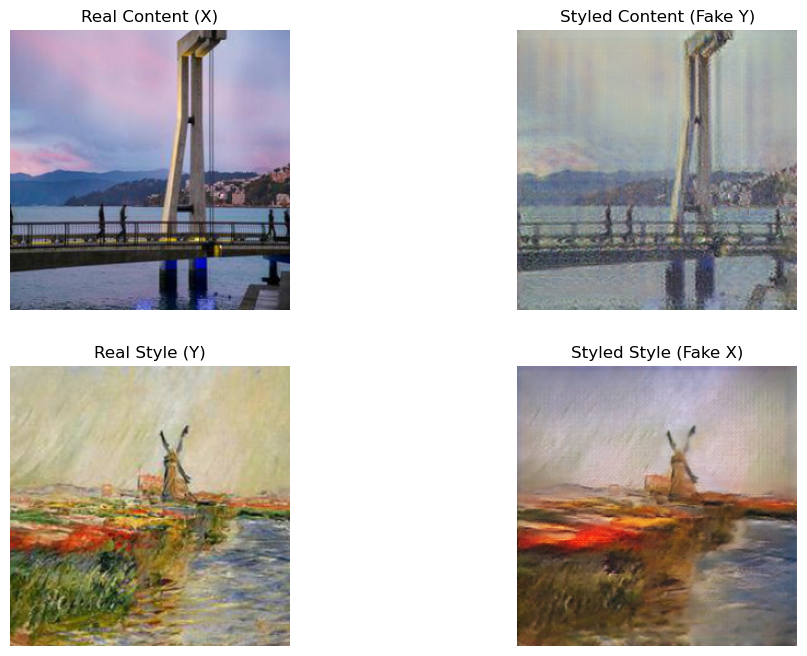

In [ ]:
# Training loop
cycle_gan_model.train()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cycle_gan_model.to(device)

# Define the training loop with checkpointing and visualization
start_epoch = 0
checkpoint_file = os.path.join(checkpoint_path, "checkpoint_epoch_20.pth")
torch.autograd.set_detect_anomaly(True)
# Load the checkpoint if it exists
start_epoch = load_checkpoint(
    checkpoint_file,
    cycle_gan_model.generator_g,
    cycle_gan_model.generator_f,
    cycle_gan_model.discriminator_x,
    cycle_gan_model.discriminator_y,
    cycle_gan_model.generator_g_optimizer,
    cycle_gan_model.generator_f_optimizer,
    cycle_gan_model.discriminator_x_optimizer,
    cycle_gan_model.discriminator_y_optimizer,
)

# Pick a sample for visualization
sample_real_x = next(iter(content_loader)).to(device)
sample_real_y = next(iter(style_loader)).to(device)

epochs = 25
for epoch in range(start_epoch, epochs):
    print(f"Epoch [{epoch + 1}/{epochs}]")

    # Training
    for real_x, real_y in zip(content_loader, style_loader):
        # Move data to device
        real_x = real_x.to(device)
        real_y = real_y.to(device)

        # Perform a single training step
        losses = cycle_gan_model.train_step(real_x, real_y)

        # Print batch losses
    print(
        f"  g_loss: {losses['g_loss']:.4f}, "
        f"f_loss: {losses['f_loss']:.4f}, "
        f"d_x_loss: {losses['d_x_loss']:.4f}, "
        f"d_y_loss: {losses['d_y_loss']:.4f}"
    )

    # Save a checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint(
            epoch + 1,
            cycle_gan_model.generator_g,
            cycle_gan_model.generator_f,
            cycle_gan_model.discriminator_x,
            cycle_gan_model.discriminator_y,
            cycle_gan_model.generator_g_optimizer,
            cycle_gan_model.generator_f_optimizer,
            cycle_gan_model.discriminator_x_optimizer,
            cycle_gan_model.discriminator_y_optimizer,
        )

        # Visualize style transfer
        with torch.no_grad():
            cycle_gan_model.eval()
            fake_y = cycle_gan_model.generator_g(sample_real_x)
            fake_x = cycle_gan_model.generator_f(sample_real_y)

            # Display the images
            display_images(sample_real_x, sample_real_y, fake_x, fake_y)
            cycle_gan_model.train()

# Chargement du modèle entraîné

Dans cette section, nous chargeons les paramètres du modèle CycleGAN à partir d'un fichier de checkpoint afin de l'utiliser pour l'évaluation. La fonction `load_checkpoint` est utilisée pour restaurer les générateurs et discriminateurs à leur état sauvegardé lors de l'entraînement.


In [ ]:
# Load the CycleGAN model for evaluation
def load_model_for_evaluation(checkpoint_file, cycle_gan_model):
    """
    Load the CycleGAN model parameters for evaluation using the existing load_checkpoint function.

    Parameters:
    - checkpoint_file: Path to the checkpoint file.
    - cycle_gan_model: The CycleGAN model instance.
    """
    # Load only the model components
    start_epoch = load_checkpoint(
        checkpoint_file,
        cycle_gan_model.generator_g,
        cycle_gan_model.generator_f,
        cycle_gan_model.discriminator_x,
        cycle_gan_model.discriminator_y,
        # Pass dummy optimizers as they're not used in evaluation
        torch.optim.Adam(cycle_gan_model.generator_g.parameters()),
        torch.optim.Adam(cycle_gan_model.generator_f.parameters()),
        torch.optim.Adam(cycle_gan_model.discriminator_x.parameters()),
        torch.optim.Adam(cycle_gan_model.discriminator_y.parameters())
    )

    # Return the epoch to indicate successful loading
    return start_epoch

# Example usage
checkpoint_file = os.path.join(checkpoint_path, "checkpoint_epoch_25.pth")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cycle_gan_model.to(device)

# Load the model for evaluation
loaded_epoch = load_model_for_evaluation(checkpoint_file, cycle_gan_model)

if loaded_epoch > 0:
    print(f"Model loaded successfully from checkpoint (epoch {loaded_epoch}).")
    # Set the model to evaluation mode
    cycle_gan_model.eval()
else:
    print("Failed to load model from checkpoint.")

C:\Users\abdennour\AppData\Local\Temp\ipykernel_21684\1028945345.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


Checkpoint loaded from ./checkpoints\checkpoint_epoch_25.pth (epoch 25)
Model loaded successfully from checkpoint (epoch 25).


### Visualisation du Transfert de Style

Nous utilisons maintenant le modèle pour visualiser comment il effectue le transfert de style.


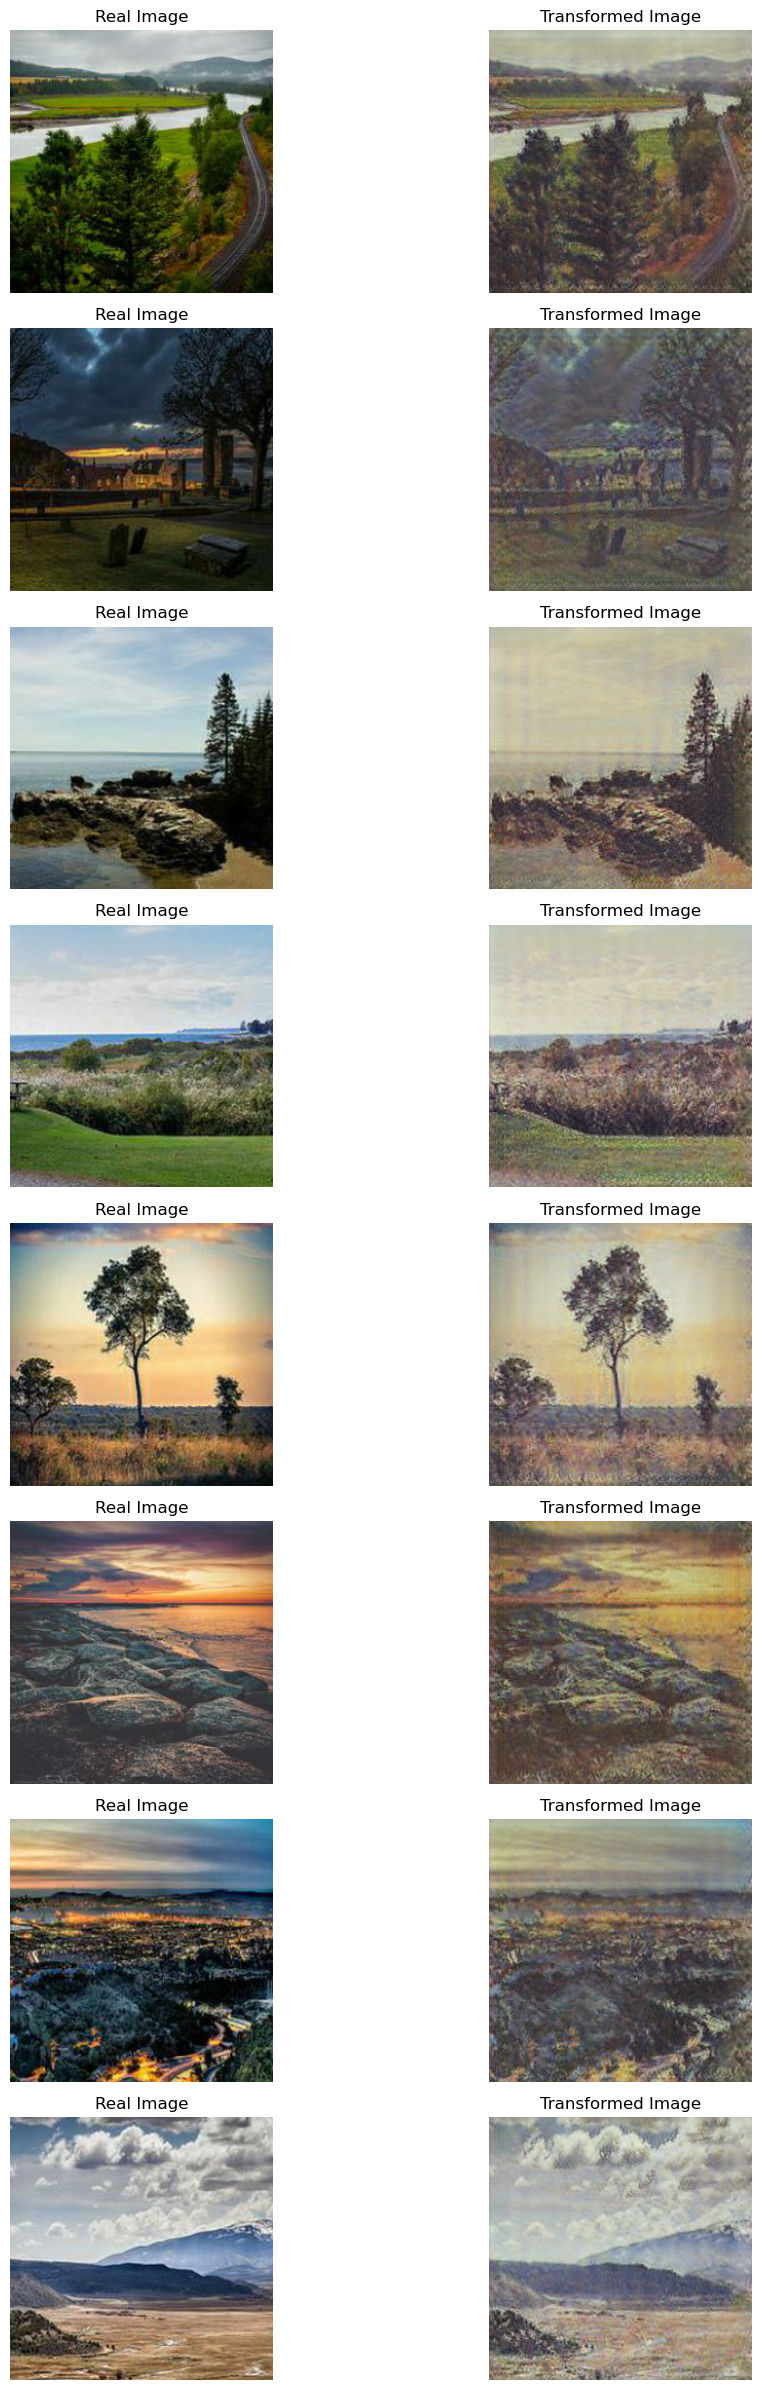

In [ ]:
def display_model_predictions(cycle_gan_model, data_loader, direction="X_to_Y", num_images=8, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], device="cpu"):
    """
    Display predictions of the CycleGAN model with denormalization.

    Parameters:
    - cycle_gan_model: The trained CycleGAN model.
    - data_loader: Data loader for the input images.
    - direction: Direction of transformation ("X_to_Y" or "Y_to_X").
    - num_images: Number of images to display (default: 8).
    - mean: Mean values for denormalization (default: [0.5, 0.5, 0.5]).
    - std: Standard deviation values for denormalization (default: [0.5, 0.5, 0.5]).
    - device: Device to run the model on ("cpu" or "cuda").
    """
    # Set model to evaluation mode
    cycle_gan_model.eval()

    # Prepare storage for images
    real_images = []
    transformed_images = []

    with torch.no_grad():
        for i, real_img in enumerate(data_loader):
            if i >= num_images:
                break
            real_img = real_img.to(device)

            # Predict the transformation
            if direction == "X_to_Y":
                transformed_img = cycle_gan_model.generator_g(real_img).to(device)
            elif direction == "Y_to_X":
                transformed_img = cycle_gan_model.generator_f(real_img).to(device)
            else:
                raise ValueError("Invalid direction. Use 'X_to_Y' or 'Y_to_X'.")

            # Denormalize images
            real_images.append(denormalize(real_img, mean, std).cpu().squeeze(0))
            transformed_images.append(denormalize(transformed_img, mean, std).cpu().squeeze(0))

    # Plot the images
    num_rows = len(real_images)
    plt.figure(figsize=(12, num_rows * 3))

    for idx, (real, transformed) in enumerate(zip(real_images, transformed_images)):
        plt.subplot(num_rows, 2, 2 * idx + 1)
        plt.title("Real Image")
        plt.imshow(real.permute(1, 2, 0))
        plt.axis('off')

        plt.subplot(num_rows, 2, 2 * idx + 2)
        plt.title("Transformed Image")
        plt.imshow(transformed.permute(1, 2, 0))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_model_predictions(
    cycle_gan_model=cycle_gan_model,
    data_loader=content_loader,
    direction="X_to_Y",
    num_images=8,
    device=device
)

### Résultats du Transfert de Style

Après la visualisation et selon nos yeux humbles, il semble que les images ressemblent à des peintures pour la plupart, donc c'est un succès !


### Évaluation Quantitative : Calcul du FCN Score

Nous passons maintenant à l'évaluation quantitative de notre modèle. Nous allons utiliser le **FCN Score** (*Fully Convolutional Network Score*), une métrique couramment utilisée pour évaluer la qualité des transformations dans les tâches de style transfer.

Le **FCN Score** mesure dans quelle mesure l'image générée conserve la structure sémantique de l'image d'origine. Pour ce faire, un réseau pré-entraîné (comme FCN-8) est utilisé pour extraire les segments sémantiques des images originales et générées. Ensuite, une similarité est calculée pour évaluer leur correspondance.

Un score élevé indique que le modèle a bien préservé la structure du contenu tout en appliquant le style. Cela nous permet d'avoir une vision plus objective des performances du modèle.

In [ ]:
from torchvision.models.segmentation import fcn_resnet50
import torch.nn.functional as F

def get_segmentation_map(image, model, device):
    """
    Generate a segmentation map for the given image using a pre-trained FCN model.

    Parameters:
    - image: A tensor of shape (1, 3, H, W), normalized.
    - model: A pre-trained FCN model.
    - device: Device to perform computations on.

    Returns:
    - seg_map: Segmentation map of shape (H, W) with class indices.
    """
    image = F.interpolate(image, size=(224, 224), mode="bilinear", align_corners=False)  # Resize for FCN input
    image = image.to(device)
    with torch.no_grad():
        output = model(image)["out"]
    seg_map = torch.argmax(output, dim=1).squeeze(0)  # Predicted class map
    return seg_map.cpu()

def compute_fcn_score(input_seg_map, output_seg_map):
    """
    Compute the FCN score as pixel accuracy.

    Parameters:
    - input_seg_map: Segmentation map for the input image (H, W).
    - output_seg_map: Segmentation map for the generated image (H, W).

    Returns:
    - accuracy: Pixel-wise accuracy score.
    """
    intersection = (input_seg_map == output_seg_map).sum().item()
    total_pixels = input_seg_map.numel()
    accuracy = intersection / total_pixels
    return accuracy

def evaluate_fcn_score(cycle_gan_model, content_loader, style_loader, device):
    """
    Evaluate the FCN Score for the CycleGAN model.

    Parameters:
    - cycle_gan_model: Trained CycleGAN model.
    - content_loader: DataLoader for content images.
    - style_loader: DataLoader for style images.
    - device: Device to perform computations on.

    Returns:
    - fcn_scores: List of FCN scores for each pair of input and generated images.
    """
    # Load pre-trained FCN model
    fcn_model = fcn_resnet50(pretrained=True).eval().to(device)

    # Set CycleGAN model to evaluation mode
    cycle_gan_model.eval()
    fcn_scores = []

    with torch.no_grad():
        for (real_x, real_y) in zip(content_loader, style_loader):
            real_x = real_x.to(device)
            real_y = real_y.to(device)

            # Generate fake images
            fake_y = cycle_gan_model.generator_g(real_x)
            fake_x = cycle_gan_model.generator_f(real_y)

            # Get segmentation maps
            input_seg_map_x = get_segmentation_map(real_x, fcn_model, device)
            output_seg_map_y = get_segmentation_map(fake_y, fcn_model, device)

            # Compute FCN score for real_x -> fake_y
            fcn_score_y = compute_fcn_score(input_seg_map_x, output_seg_map_y)
            fcn_scores.append(fcn_score_y)

            # Optional: Evaluate style (real_y -> fake_x) if needed
            input_seg_map_y = get_segmentation_map(real_y, fcn_model, device)
            output_seg_map_x = get_segmentation_map(fake_x, fcn_model, device)
            fcn_score_x = compute_fcn_score(input_seg_map_y, output_seg_map_x)
            fcn_scores.append(fcn_score_x)

    return fcn_scores

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn_scores = evaluate_fcn_score(cycle_gan_model, content_loader, style_loader, device)
average_fcn_score = sum(fcn_scores) / len(fcn_scores)

print(f"Average FCN Score: {average_fcn_score:.4f}")

Average FCN Score: 0.9895


### Résultat du FCN Score

Nous avons obtenu un **FCN Score de 0.98**, ce qui est un excellent résultat ! Cela montre que le modèle a très bien préservé la structure sémantique des images tout en effectuant la transformation de style.

Cependant, il est important de noter que ce score a été calculé sur le **jeu d'entraînement**, où les performances sont souvent optimales. Il est donc normal d'obtenir un score aussi élevé dans ce contexte. Pour une évaluation plus complète, il serait pertinent de tester le modèle sur des données non vues.


## Évaluation Quantitative : Calcul du FID Score

Nous allons maintenant évaluer notre modèle avec le **FID (Fréchet Inception Distance)**.


In [ ]:
from torch_fidelity import calculate_metrics
from torchvision.datasets import ImageFolder


def generate_images(cycle_gan_model, data_loader, output_dir, device):
    os.makedirs(output_dir, exist_ok=True)
    cycle_gan_model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for i, real_x in enumerate(data_loader):
            real_x = real_x.to(device)
            fake_y = cycle_gan_model.generator_g(real_x).to(device)
            fake_y = denormalize(fake_y, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            # Denormalize and save generated images
            for j, img in enumerate(fake_y):
                save_path = os.path.join(output_dir, f"generated_{i * len(real_x) + j}.png")
                transforms.ToPILImage()(img.clamp(0, 1).cpu()).save(save_path)

image_path = "data/photo_jpg"
generated_images_dir = "data/generated"

# Prepare datasets and loaders for real and generated images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

content_dataset = ImageDataset(image_path, transform=image_transforms)
real_loader = DataLoader(content_dataset, batch_size=1, shuffle=False)

# Generate images using the CycleGAN model
generate_images(cycle_gan_model, real_loader, generated_images_dir, device)

# Calculate FID score
metrics = calculate_metrics(
    input1=image_path,
    input2=generated_images_dir,
    cuda=torch.cuda.is_available(),
    isc=False,  # Inception Score, optional
    fid=True  # Compute FID
)

# Print the FID score
print(f"FID Score: {metrics['frechet_inception_distance']}")

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "data/photo_jpg" with extensions png,jpg,jpeg
Found 7038 samples, some are lossy-compressed - this may affect metrics
Processing samples                                                           
Extracting statistics from input 2
Looking for samples non-recursivelty in "data/generated" with extensions png,jpg,jpeg
Found 7038 samples
Processing samples                                                           


FID Score: 85.00924602344753


Frechet Inception Distance: 85.00924602344753


Le score FID que nous avons obtenu est de **85**, ce qui est tout à fait logique dans notre cas.

### Pourquoi un FID de 85 ?
L'objectif de notre modèle est de transférer le style, donc nous voulons que les images générées ressemblent aux images originales, mais sans être des copies exactes. Un score FID élevé, comme celui-ci, peut être interprété comme une bonne chose dans le cadre du transfert de style, car il montre que les images générées ont suffisamment de différences avec les images originales pour refléter le processus de transfert de style tout en conservant une certaine similitude.

En résumé, ce score est raisonnable et montre que notre modèle fonctionne comme prévu : il réussit à transférer le style tout en maintenant une certaine cohérence visuelle avec les images d'origine. Cela reste un résultat positif pour notre tâche de style transfer ! 🎨


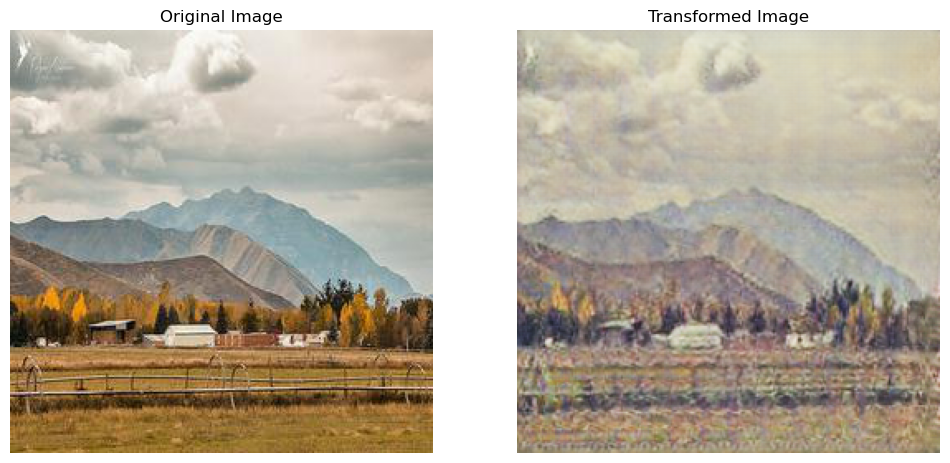

In [ ]:
def process_and_display_image(cycle_gan_model, image_path, device, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Process a new image, generate the result with CycleGAN, and display the original and transformed images side by side.

    Parameters:
    - cycle_gan_model: The trained CycleGAN model.
    - image_path: Path to the new image to be processed.
    - device: Device to run the model (CPU or GPU).
    - mean: Mean values for normalization (default [0.5, 0.5, 0.5]).
    - std: Standard deviation values for normalization (default [0.5, 0.5, 0.5]).
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Define the image transformation (resize, to tensor, normalization)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Apply transformation
    input_image = transform(image).unsqueeze(0).to(device)

    # Generate the result with the model (assuming generator_g for style transfer)
    with torch.no_grad():
        cycle_gan_model.eval()
        transformed_image = cycle_gan_model.generator_g(input_image)

    # Denormalize the images
    def denormalize(tensor, mean, std):
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor.clamp(0, 1)

    original_image = denormalize(input_image.squeeze(0).cpu(), mean, std)
    transformed_image = denormalize(transformed_image.squeeze(0).cpu(), mean, std)

    # Display the images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image.permute(1, 2, 0))
    plt.axis('off')

    # Transformed image
    plt.subplot(1, 2, 2)
    plt.title("Transformed Image")
    plt.imshow(transformed_image.permute(1, 2, 0))
    plt.axis('off')

    plt.show()

# Example usage
image_path = "real_image.jpg"
process_and_display_image(cycle_gan_model, image_path, device)